# **Suicide Detection - BERT Model**


# **Environment Settings**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install -qqq praw unidecode contractions wordninja symspellpy pyspellchecker

In [3]:
import praw

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spacy
import unidecode
import contractions as contract
import re
import wordninja
import collections
import pkg_resources
from spellchecker import SpellChecker
from symspellpy import SymSpell, Verbosity
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from torchvision import models
import torch.nn.functional as F
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import os
import time
import random

# **Web Scraping and Sanity Check**

In [ ]:
# initialize Reddit API credentials
# sensitive information being replaced by XXX
reddit = praw.Reddit(client_id='XXX',
                     client_secret='XXX',
                     username='XXX',
                     password='XXX',
                     user_agent='XXX',
                     check_for_async=False)

In [ ]:
# define a function to get posts from a subreddit and save to a csv file
def get_posts(subreddit_name, num_posts):
    posts = []
    subreddit = reddit.subreddit(subreddit_name)
    for post in subreddit.hot(limit=num_posts):
        posts.append([post.title, post.selftext, post.subreddit])
    post = pd.DataFrame(posts, columns=['post_title', 'post_body', 'label'])
    post.to_csv('/content/drive/MyDrive/IMT574/'+subreddit_name + '.csv')
    return post

In [ ]:
# retrieve posts from specified subreddits
get_posts('depression', 1000)
get_posts('offmychest', 1000)
get_posts('SuicideWatch', 1000)
get_posts('teenagers', 1000)

df_dep = pd.read_csv('/content/drive/MyDrive/IMT574/depression.csv')
df_omc = pd.read_csv('/content/drive/MyDrive/IMT574/offmychest.csv')
df_sw = pd.read_csv('/content/drive/MyDrive/IMT574/SuicideWatch.csv')
df_tg = pd.read_csv('/content/drive/MyDrive/IMT574/teenagers.csv')

In [ ]:
# merged datasets into one
df_post = pd.concat([df_dep, df_omc, df_sw, df_tg], ignore_index=True)
df_post = df_post.drop(columns=['Unnamed: 0', 'post_title'])

# map labels to binary values
label_mapping = {'depression': 1, 'SuicideWatch': 1, 'teenagers': 0, 'offmychest': 0}
df_post['label'] = df_post['label'].map(label_mapping)

In [ ]:
# check NA values
df_post.isnull().sum()

post_body    252
label          0
dtype: int64

In [ ]:
# check data types
df_post.dtypes

post_body    object
label         int64
dtype: object

# **Data Preprocessing**

In [ ]:
# this section is modified based on the reference: https://github.com/gohjiayi/suicidal-text-detection/blob/main/data_preprocessing.ipynb
# initialize SymSpell
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")
vocab = collections.Counter()
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# spell check
def fix_spelling(post):
    suggestions = sym_spell.lookup_compound(post, max_edit_distance=2)
    correctedtext = suggestions[0].term # get the first suggestion or returns original text
    return correctedtext

# remove privative words from stopwords list
deselect_stop_words = ['no', 'not']
for n in deselect_stop_words:
    nlp.vocab[n].is_stop = False

# remove extra whitespaces
def remove_extra_whitespace(post):
    post = post.strip()
    return " ".join(post.split())

# remove accented characters
def remove_accented_characters(post):
    post = unidecode.unidecode(post)
    return post

# removing special characters
def remove_special_characters(post):
    return post.replace("\r", " ").replace("\n", " ").replace("    ", " ").replace('"', '')

# remove URL
def remove_url(post):
    return re.sub(r'http\S+', '', post)

# removing symbols and digits
def remove_symbols_digits(post):
    return re.sub('[^a-zA-Z\s]', ' ', post)

# fix word lengthening (characters are wrongly repeated)
def fix_lengthening(post):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", post)

# main text preprocessing function
def text_preprocessing(post, accented_characters=True, contractions=True, lowercase=True, url=True, symbols_digits=True, special_characters=True, extra_whitespace=True, lengthening=True, spelling=True,
                       convert_num=True, lemmatization=True,  stop_words=True):
    # preprocess text with default option set to true for all steps
    post = str(post)
    if accented_characters == True:
        post = remove_accented_characters(post)
    if contractions == True:
        post = contract.fix(post)
    if lowercase == True:
        post = post.lower()
    if url == True:
        post = remove_url(post)
    if symbols_digits == True:
        post = remove_symbols_digits(post)
    if special_characters == True:
        post = remove_special_characters(post)
    if extra_whitespace == True:
        post = remove_extra_whitespace(post)
    if lengthening == True:
        post = fix_lengthening(post)
    if spelling == True:
        post = fix_spelling(post)

    doc = nlp(post)
    cleaned_post = []

    for token in doc:
        flag = True
        edit = token.text
        # remove stop words
        if stop_words == True and token.is_stop and token.pos_ != 'NUM':
            flag = False
        # exclude number words
        if convert_num == True and token.pos_ == 'NUM' and flag == True:
            flag = False
        # convert tokens to base form
        elif lemmatization == True and token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_
        # append tokens edited and not removed to list
        if edit != "" and flag == True:
            cleaned_post.append(edit)
    return " ".join(cleaned_post)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# apply text preprocessing function to 'post_body' column
tqdm.pandas(desc="Processing")
df_post['post_body'] = df_post['post_body'].progress_apply(lambda row: text_preprocessing(row))

# save cleaned data to CSV
df_post.to_csv('/content/drive/MyDrive/IMT574/cleaned_data.csv')

In [8]:
df_cleaned_post = pd.read_csv('/content/drive/MyDrive/IMT574/cleaned_data.csv')
df_cleaned_post.head(10)

,post_body,label
0,understand people reply immediately invitation...,1
1,welcome depression check post place moment sha...,1
2,dentist today normal checkup fucking cavity ti...,1
3,not kind weird live long outlive majority spec...,1
4,catch countless time talk somebody not listen ...,1
5,mere fact depression fear worry sadness guilt ...,1
6,depression want forget awhile memory clinicall...,1
7,grow not suppose hard feel like dig pit no mat...,1
8,struggle hard deal depression past bad pointle...,1
9,year old female issue depression self esteem i...,1


In [9]:
# check dataset balance
label_suicide = df_cleaned_post['label'].eq(1).sum()
label_nonsuicide = df_cleaned_post['label'].eq(0).sum()
print('Number of suicide case:',label_suicide)
print('Number of nonsuicide case:',label_nonsuicide)

Number of suicide case: 1726
Number of nonsuicide case: 1455


**Dataset Description:**
The dataset is obtained from Reddit. The data spans mostly the last 2-3 years and comprises 'hot'(popular) posts from various subreddit forums, some related to suicide and others not related. The purpose of this dataset is to explore mental health problems, particularly depression, in contemporary online discourse.

**Features:**
The dataset consists of two columns:
1. Feature column: This includes the content of the posts scraped from Reddit.
2. Target column: This column contains the labels assigned to each post. The labels are divided into two classes:
   - 'Suicide': Posts collected from subreddits 'SuicideWatch' and 'depression', assumed to contain suicide-related content.
   - 'Non-suicide': Posts from other subreddits 'teenagers' and 'offmychest', assumed not to contain suicide-related content.
   The dataset is balance since the numbers of two classes are close.

**Data Collection:**
The data was collected through web scraping using praw, with posts gathered from various subreddit forums.

**Important Notes:**
1. The class labels were assigned based on the source subreddit. Here I assume that posts from specific subreddits contain content related to suicide, which may not always be accurate. There could be misclassification or overlap between different topics.
2. The dataset's primary focus is on exploring mental health issues, particularly depression, as discussed in online communities. However, it's essential to acknowledge the limitations of using subreddit categorization as a basis for labeling posts.
3. As proceeding with analysis, it's crucial to interpret the results with an understanding of these assumptions and potential biases inherent in the dataset.

**Research Question:**
How can the textual content of online posts be used to predict the suicidal intention among individuals?

**Explanation:**
In this research, I aim to explore the relationship between the language used in online posts and the underlying mental health concerns, particularly suicidal ideation. By analyzing the textual content of posts gathered from various subreddits, the objective is to develop a predictive model that can identify the suicidal intention. Therefore, the research falls under supervised learning and it is a classification task. The goal is to learn a mapping from input features (textual content) to the corresponding output labels (suicidal or non-suicidal).

**Expected Accomplishments:**
1. **Understanding linguistic patterns:** By analyzing the language patterns present in online posts, we can gain insights into the linguistic cues associated with suicidal ideation. This understanding can help with prediction and contribute to the development of more effective intervention strategies for mental health support.
2. **Early detection:** A predictive model capable of identifying the suicidal intention based on online posts could serve as an early detection tool. This could potentially lead to timely interventions and support for individuals at risk of self-harm or suicide.

# **BERT Model**

In [10]:
# set random seed
torch.manual_seed(12)
random.seed(12)
np.random.seed(12)

In [11]:
# determine features and targets
X = df_cleaned_post["post_body"].astype(str).tolist()
y = df_cleaned_post["label"].astype(int).tolist()

# split data into training, testing, and validation sets
train_ratio = 0.7
test_ratio = 0.2
validation_ratio = 0.1
train_texts, test_texts, train_labels, test_labels = train_test_split(X, y, test_size=1 - train_ratio, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(test_texts, test_labels, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

In [12]:
# tokenize and encode text data using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

# convert encodings to PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']),
                                               torch.tensor(train_encodings['attention_mask']),
                                               torch.tensor(train_labels))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']),
                                              torch.tensor(test_encodings['attention_mask']),
                                              torch.tensor(test_labels))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(val_encodings['input_ids']),
                                             torch.tensor(val_encodings['attention_mask']),
                                             torch.tensor(val_labels))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The algorithm I choose to apply in this research is BERT (Bidirectional Encoder Representations from Transformers), which is a Neural Network model.

Reasons for choose BERT:
1. **Pre-trained contextual understanding:**
   BERT is a transformer-based model pre-trained on large corpora of text data, enabling it to capture contextual relationships between words and phrases effectively. This contextual understanding is essential for accurately interpreting the nuanced language in online posts and allows BERT to learn rich, contextual sentences.

2. **Bi-directional attention:**
   Compared to traditional models like LSTM (Long Short-Term Memory) which process texts sequentially forward, bi-directional attention mechanism is applied to BERT enables it to both left and right context when encoding each word. Therefore, BERT has the strong capacity to capture dependencies and relationships among sentences moe comprehensively, which can be beneficial for understanding context of language especially in emotional discussions.

3. **Robust Performance:**
   BERT is a model frequently used in NLP tasks such as sentiment analysis, text classification, suggesting BERT is suitable for handling complex posts in online discussions.

In [13]:
# check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available!")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available!")
else:
    device = torch.device("cpu")
    print("Use CPU only.")

CUDA is available!


In [14]:
# model settings
epochs = 11
lr = 1e-5
batch_size = 20

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch [1/11], Batch [112/112], Loss: 0.8999:   9%|▉         | 112/1232 [03:10<25:27,  1.36s/it]

Epoch [1/11], Training Accuracy: 69.14%
Validation Accuracy: 75.47%


Epoch [2/11], Batch [112/112], Loss: 0.3202:  18%|█▊        | 224/1232 [06:36<22:54,  1.36s/it]

Epoch [2/11], Training Accuracy: 79.92%
Validation Accuracy: 77.04%


Epoch [3/11], Batch [112/112], Loss: 0.2731:  27%|██▋       | 336/1232 [10:02<20:27,  1.37s/it]

Epoch [3/11], Training Accuracy: 83.56%
Validation Accuracy: 80.50%


Epoch [4/11], Batch [112/112], Loss: 0.1394:  36%|███▋      | 448/1232 [13:23<17:56,  1.37s/it]

Epoch [4/11], Training Accuracy: 88.05%
Validation Accuracy: 79.25%


Epoch [5/11], Batch [112/112], Loss: 0.5410:  45%|████▌     | 560/1232 [16:45<15:19,  1.37s/it]

Epoch [5/11], Training Accuracy: 91.28%
Validation Accuracy: 80.50%


Epoch [6/11], Batch [112/112], Loss: 0.0463:  55%|█████▍    | 672/1232 [20:06<12:44,  1.37s/it]

Epoch [6/11], Training Accuracy: 94.29%
Validation Accuracy: 79.87%


Epoch [7/11], Batch [112/112], Loss: 0.0271:  64%|██████▎   | 784/1232 [23:28<10:09,  1.36s/it]

Epoch [7/11], Training Accuracy: 96.09%
Validation Accuracy: 77.99%


Epoch [8/11], Batch [112/112], Loss: 0.0365:  73%|███████▎  | 896/1232 [26:49<07:39,  1.37s/it]

Epoch [8/11], Training Accuracy: 97.12%
Validation Accuracy: 77.36%


Epoch [9/11], Batch [112/112], Loss: 0.0208:  82%|████████▏ | 1008/1232 [30:13<05:05,  1.36s/it]

Epoch [9/11], Training Accuracy: 98.25%
Validation Accuracy: 79.87%


Epoch [10/11], Batch [112/112], Loss: 0.0089:  91%|█████████ | 1120/1232 [33:35<02:32,  1.36s/it]

Epoch [10/11], Training Accuracy: 97.35%
Validation Accuracy: 78.62%


Epoch [11/11], Batch [112/112], Loss: 0.0230: 100%|██████████| 1232/1232 [36:57<00:00,  1.37s/it]

Epoch [11/11], Training Accuracy: 98.38%
Validation Accuracy: 79.87%


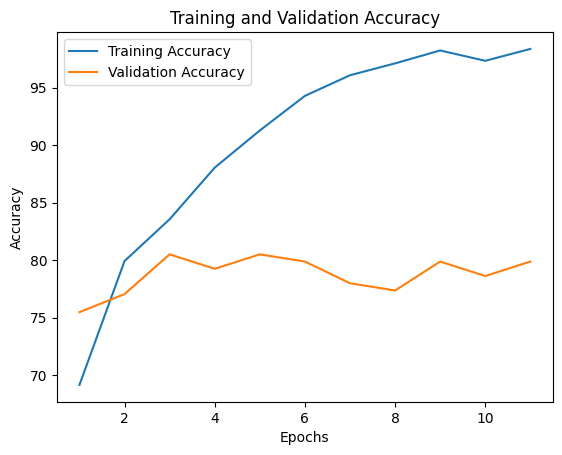

In [15]:
# load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# define optimizer and data loaders
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model.train()

total_batches = len(train_loader) * epochs
progress_bar = tqdm(total=total_batches)

train_accuracies = []
val_accuracies = []

# training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, batch in enumerate(train_loader):
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids= input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        # calculate correctness
        running_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.update(1)
        progress_bar.set_description(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")


    # print epoch-wise training accuracy
    train_epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Training Accuracy: {train_epoch_accuracy:.2f}%")
    torch.save(model.state_dict(), '/content/drive/MyDrive/IMT574/model'+str(epoch)+'.pth')
    train_accuracies.append(train_epoch_accuracy)


    # validate the model
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=20, shuffle=False)

    model.eval()
    val_predictions = []
    val_true_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, predicted = torch.max(logits, 1)
            val_predictions.extend(predicted.tolist())
            val_true_labels.extend(labels.tolist())

    # calculate validation accuracy
    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    val_accuracies.append(val_accuracy*100)

# plot training and validation accuracies
epochs_list = range(1, epochs + 1)

plt.plot(epochs_list, train_accuracies, label='Training Accuracy')
plt.plot(epochs_list, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Accuracy: 83.83%


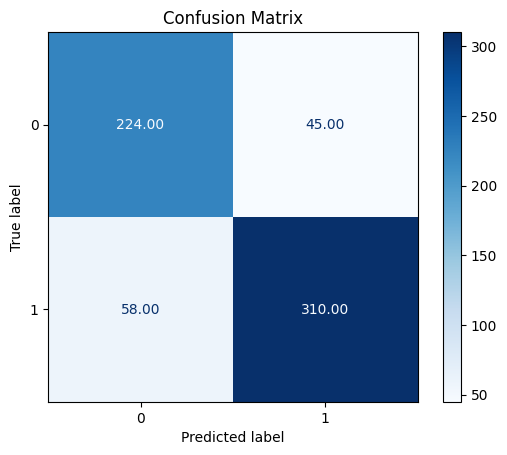

In [17]:
# load the best model from fine-tune attempts
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
checkpoint = '/content/drive/MyDrive/IMT574/model_best.pth'
model.load_state_dict(torch.load(checkpoint))

# final evaluate test the model
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=False)

model.eval()
test_predictions = []
test_true_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)
        test_predictions.extend(predicted.tolist())
        test_true_labels.extend(labels.tolist())

# calculate test accuracy
test_accuracy = accuracy_score(test_true_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# plot the confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='.2f')
plt.title('Confusion Matrix')
plt.show()

**First Fine-tuning Attempt - Appendix 1:**

- **Epochs:** 15
- **Learning Rate (lr):** 1e-5
- **Batch Size:** 20
- **Final Test Accuracy:** 82.57%
- The model stuck with the local minimal problem when optimizing parameters after 15 epochs.

**Second Fine-tuning Attempt - Appendix 2:**
- **Epochs:** 20
- **Learning Rate (lr):** 2e-5
- **Batch Size:** 16
- **Final Test Accuracy:** 82.71%
- The model has difficulties in convergence.

**Third Fine-tuning Attempt - Appendix 3:**
- **Epochs:** 10
- **Learning Rate (lr):** 3e-5
- **Batch Size:** 16
- **Final Test Accuracy:** 79.10%
- The learning rate is too large and its performance is unstable.

The charts provide validation accuracy line and training accuracy line in different model settings. All the three models showed the solid training accuracies, each reaching a peak around 98%. However, the validation accuracy did not exhibit the same level of improvement, suggesting that the model have started overfitting to the training data. This is a typical indication that the model is learning patterns specific to the training data (memorizing training data) that do not generalize well to unseen data.

**Final Model Settings:**
- **Epochs:** 11
- **Learning Rate (lr):** 1e-5
- **Batch Size:** 20
- **Final Test Accuracy:** 83.83%

The final model settings I settled on are based on my first fine-tuning attempt. It balances the learning rate and batch size, and stops the training at the peak of validation accuracy to avoid further overfitting.

1. Long training time:
One significant challenge was the long training time required for BERT model. To mitigate the difficulty, I shuffled the dataset and only use a small proportion data when initially developing the model. Additionally, leveraging cloud-based computing resources such as Colab allows me to training several models with different model settings at the same time which significantly reduces training time and improves overall efficiency.

2. Randomness and model reproducibility:
Another challenge was ensuring reproducibility and consistency across model training runs due to the inherent randomness involved in training neural networks. Inconsistent results between runs can make it difficult to assess the effectiveness of parameter optimization or compare model performance accurately. To address this, I controlled randomness by setting a fixed random seed at the beginning of model training and save the model state after each epoch, enabling easy reproducibility and resume training from a specific checkpoint if necessary.

**Explanation of the answer to research question:**
By training BERT on a dataset containing labeled posts from various subreddits, the model effectively learns to identify linguistic patterns and contextual cues indicative of suicidal ideation. Through this supervised learning process, the model is trained to classify posts as either containing suicidal content or not, thereby providing insights into the relationship between language use in posts and mental health concerns.

**Risks and Advantages of applying the solution to unseen data & Consequences:**

*Risks:*
- Overreliance on AI systems: Relying solely on automated systems to detect and intervene in cases of suicidal intention may lead to inappropriate interventions or missed opportunities for support when the model is wrong.
- Privacy concerns and ethical considerations: Automated monitoring of online content raises privacy concerns regarding the surveillance and profiling of individuals’ mental health conditions without explicit consent.
*Negative consequences:*
- False alarms: Incorrectly flagging non-suicidal posts as indicative of suicidal intention (false positives) may lead to unnecessary distress or intervention for individuals, potentially exacerbating their mental health issues.
- Missed signals: Failing to identify posts containing genuine signals of suicidal ideation (false negatives) could result in missed opportunities for providing support and intervention.

*Advantages:*
- Early intervention: Automated detection of suicidal intention allows for timely intervention and mental support, potentially saving lives by providing professional assistance to individuals in distress.
*Positive consequences:*
- Timely assistance: Accurately identifying individuals at risk of suicidal behavior allows for timely intervention and support, mitigating the severity of mental health crises.
- Scalability: The model can be applied to large volumes of online posts, allowing for efficient screening and monitoring of online communities for signs of distress.

**Societal impacts:**

*Negative impacts:*
- Stigmatization: Misclassification(or correct classification) of posts may reinforce stereotypes and stigmatization surrounding mental health issues, leading to potential marginalization of affected individuals.
- Privacy concerns: Automated monitoring of online content without consent may erode trust in online platforms and their ability to handle sensitive personal information.

*Positive impacts:*
- Support and empowerment: Providing timely support and resources to individuals in distress empowers them to seek help and navigate their mental health challenges more effectively.
- Raise social awareness: By fostering open discussions and support networks for mental health, the solution contributes to building more inclusive and supportive online communities, where individuals feel comfortable seeking help and sharing their experiences without fear of judgment.

**Potential research question:**
How do online community dynamics relate to mental health discussions?

**Importance:**
Understanding the role of online community dynamics in shaping attitudes, behaviors, and support mechanisms related to mental health is important for developing more targeted interventions and more supportive systems. It can contribute to the development of more effective intervention strategies and platform policies to foster safe, supportive, and inclusive online environments for individuals struggling with mental health issues.

### **Appendix 1**

**model settings:**
**epochs = 15**
**lr = 1e-5**
**batch_size = 20**
**Final test accuracy = 82.57%**

Epoch [1/15], Batch [112/112], Loss: 0.8999:   7%|▋         | 112/1680 [03:14<37:04,  1.42s/it]
Epoch [1/15], Training Accuracy: 69.14%
Validation Accuracy: 75.47%

Epoch [2/15], Batch [112/112], Loss: 0.4984:  13%|█▎        | 224/1680 [07:05<34:23,  1.42s/it]
Epoch [2/15], Training Accuracy: 79.20%
Validation Accuracy: 81.45%

Epoch [3/15], Batch [112/112], Loss: 0.2105:  20%|██        | 336/1680 [10:57<31:40,  1.41s/it]
Epoch [3/15], Training Accuracy: 85.76%
Validation Accuracy: 80.82%

Epoch [4/15], Batch [112/112], Loss: 0.4798:  27%|██▋       | 448/1680 [14:48<29:04,  1.42s/it]
Epoch [4/15], Training Accuracy: 88.59%
Validation Accuracy: 81.76%

Epoch [5/15], Batch [112/112], Loss: 0.1621:  33%|███▎      | 560/1680 [18:43<26:28,  1.42s/it]
Epoch [5/15], Training Accuracy: 92.32%
Validation Accuracy: 81.45%

Epoch [6/15], Batch [112/112], Loss: 0.0683:  40%|████      | 672/1680 [22:39<23:46,  1.42s/it]
Epoch [6/15], Training Accuracy: 94.88%
Validation Accuracy: 77.99%

Epoch [7/15], Batch [112/112], Loss: 0.0144:  47%|████▋     | 784/1680 [26:35<21:10,  1.42s/it]
Epoch [7/15], Training Accuracy: 96.81%
Validation Accuracy: 79.87%

Epoch [8/15], Batch [112/112], Loss: 0.0128:  53%|█████▎    | 896/1680 [30:27<18:30,  1.42s/it]
Epoch [8/15], Training Accuracy: 97.75%
Validation Accuracy: 77.04%

Epoch [9/15], Batch [112/112], Loss: 0.0242:  60%|██████    | 1008/1680 [34:19<15:52,  1.42s/it]
Epoch [9/15], Training Accuracy: 98.20%
Validation Accuracy: 78.30%

Epoch [10/15], Batch [112/112], Loss: 0.4199:  67%|██████▋   | 1120/1680 [38:10<13:13,  1.42s/it]
Epoch [10/15], Training Accuracy: 98.25%
Validation Accuracy: 77.36%

Epoch [11/15], Batch [112/112], Loss: 0.0079:  73%|███████▎  | 1232/1680 [42:02<10:35,  1.42s/it]
Epoch [11/15], Training Accuracy: 96.77%
Validation Accuracy: 81.13%

Epoch [12/15], Batch [112/112], Loss: 0.0078:  80%|████████  | 1344/1680 [45:53<07:57,  1.42s/it]
Epoch [12/15], Training Accuracy: 98.20%
Validation Accuracy: 78.30%

Epoch [13/15], Batch [112/112], Loss: 0.0082:  87%|████████▋ | 1456/1680 [49:44<05:16,  1.41s/it]
Epoch [13/15], Training Accuracy: 99.15%
Validation Accuracy: 78.93%

Epoch [14/15], Batch [112/112], Loss: 0.3775:  93%|█████████▎| 1568/1680 [53:40<02:38,  1.41s/it]
Epoch [14/15], Training Accuracy: 98.70%
Validation Accuracy: 80.19%

Epoch [15/15], Batch [112/112], Loss: 0.0043: 100%|██████████| 1680/1680 [57:31<00:00,  1.41s/it]
Epoch [15/15], Training Accuracy: 99.24%
Validation Accuracy: 78.93%

### **Appendix 2**

**model settings:**
**epochs = 20**
**lr = 2e-5**
**batch_size = 16**
**Final test accuracy = 82.71%**

Epoch [1/20], Batch [157/157], Loss: 0.3845:   5%|▌         | 157/3140 [03:39<1:06:54,  1.35s/it]
Epoch [1/20], Training Accuracy: 74.92%
Validation Accuracy: 83.80%

Epoch [2/20], Batch [157/157], Loss: 0.1777:  10%|█         | 314/3140 [08:09<1:05:32,  1.39s/it]
Epoch [2/20], Training Accuracy: 85.21%
Validation Accuracy: 82.96%

Epoch [3/20], Batch [157/157], Loss: 0.3638:  15%|█▌        | 471/3140 [12:46<1:02:01,  1.39s/it]
Epoch [3/20], Training Accuracy: 91.19%
Validation Accuracy: 80.73%

Epoch [4/20], Batch [157/157], Loss: 0.1403:  20%|██        | 628/3140 [17:21<58:11,  1.39s/it]
Epoch [4/20], Training Accuracy: 95.30%
Validation Accuracy: 79.89%

Epoch [5/20], Batch [157/157], Loss: 0.0077:  25%|██▌       | 785/3140 [21:59<54:23,  1.39s/it]
Epoch [5/20], Training Accuracy: 96.49%
Validation Accuracy: 80.73%

Epoch [6/20], Batch [157/157], Loss: 0.0195:  30%|███       | 942/3140 [26:37<51:13,  1.40s/it]
Epoch [6/20], Training Accuracy: 97.45%
Validation Accuracy: 81.01%

Epoch [7/20], Batch [157/157], Loss: 0.1627:  35%|███▌      | 1099/3140 [31:13<47:12,  1.39s/it]
Epoch [7/20], Training Accuracy: 97.65%
Validation Accuracy: 82.12%

Epoch [8/20], Batch [157/157], Loss: 0.1475:  40%|████      | 1256/3140 [35:50<43:29,  1.39s/it]
Epoch [8/20], Training Accuracy: 98.64%
Validation Accuracy: 82.12%

Epoch [9/20], Batch [157/157], Loss: 0.0289:  45%|████▌     | 1413/3140 [40:29<39:46,  1.38s/it]
Epoch [9/20], Training Accuracy: 98.33%
Validation Accuracy: 82.12%

Epoch [10/20], Batch [157/157], Loss: 0.0803:  50%|█████     | 1570/3140 [45:02<36:12,  1.38s/it]
Epoch [10/20], Training Accuracy: 97.81%
Validation Accuracy: 82.40%

Epoch [11/20], Batch [157/157], Loss: 0.0614:  55%|█████▌    | 1727/3140 [49:37<32:41,  1.39s/it]
Epoch [11/20], Training Accuracy: 97.85%
Validation Accuracy: 79.61%

Epoch [12/20], Batch [157/157], Loss: 0.0115:  60%|██████    | 1884/3140 [54:11<28:57,  1.38s/it]
Epoch [12/20], Training Accuracy: 98.68%
Validation Accuracy: 82.12%

Epoch [13/20], Batch [157/157], Loss: 0.0111:  65%|██████▌   | 2041/3140 [58:49<25:21,  1.38s/it]
Epoch [13/20], Training Accuracy: 98.29%
Validation Accuracy: 83.80%

Epoch [14/20], Batch [157/157], Loss: 0.0216:  70%|███████   | 2198/3140 [1:03:23<21:42,  1.38s/it]
Epoch [14/20], Training Accuracy: 98.64%
Validation Accuracy: 82.96%

Epoch [15/20], Batch [157/157], Loss: 0.0171:  75%|███████▌  | 2355/3140 [1:08:01<18:05,  1.38s/it]
Epoch [15/20], Training Accuracy: 98.17%
Validation Accuracy: 82.96%

Epoch [16/20], Batch [157/157], Loss: 0.0014:  80%|████████  | 2512/3140 [1:12:35<14:32,  1.39s/it]
Epoch [16/20], Training Accuracy: 98.60%
Validation Accuracy: 80.17%

Epoch [17/20], Batch [157/157], Loss: 0.0240:  85%|████████▌ | 2669/3140 [1:17:08<10:52,  1.39s/it]
Epoch [17/20], Training Accuracy: 98.64%
Validation Accuracy: 82.12%

Epoch [18/20], Batch [157/157], Loss: 0.0198:  90%|█████████ | 2826/3140 [1:21:44<07:13,  1.38s/it]
Epoch [18/20], Training Accuracy: 98.29%
Validation Accuracy: 81.01%

Epoch [19/20], Batch [157/157], Loss: 0.0118:  95%|█████████▌| 2983/3140 [1:26:21<03:38,  1.39s/it]
Epoch [19/20], Training Accuracy: 98.37%
Validation Accuracy: 78.77%

Epoch [20/20], Batch [157/157], Loss: 0.0133: 100%|██████████| 3140/3140 [1:30:59<00:00,  1.39s/it]
Epoch [20/20], Training Accuracy: 98.44%
Validation Accuracy: 81.28%

### **Appendix 3**

**model settings:**
**epochs = 10**
**lr = 3e-5**
**batch_size = 16**
**Final test accuracy = 79.10%**

Epoch [1/10], Batch [160/160], Loss: 0.5917:  10%|█         | 160/1600 [03:33<30:49,  1.28s/it]
Epoch [1/10], Training Accuracy: 69.42%
Validation Accuracy: 77.53%

Epoch [2/10], Batch [160/160], Loss: 0.6887:  20%|██        | 320/1600 [07:48<27:41,  1.30s/it]
Epoch [2/10], Training Accuracy: 82.09%
Validation Accuracy: 81.37%

Epoch [3/10], Batch [160/160], Loss: 0.1274:  30%|███       | 480/1600 [12:08<24:14,  1.30s/it]
Epoch [3/10], Training Accuracy: 86.55%
Validation Accuracy: 78.08%

Epoch [4/10], Batch [160/160], Loss: 0.3123:  40%|████      | 640/1600 [16:28<20:47,  1.30s/it]
Epoch [4/10], Training Accuracy: 90.18%
Validation Accuracy: 79.73%

Epoch [5/10], Batch [160/160], Loss: 0.1822:  50%|█████     | 800/1600 [20:45<17:27,  1.31s/it]
Epoch [5/10], Training Accuracy: 94.41%
Validation Accuracy: 79.18%

Epoch [6/10], Batch [160/160], Loss: 0.0254:  60%|██████    | 960/1600 [25:04<13:56,  1.31s/it]
Epoch [6/10], Training Accuracy: 95.74%
Validation Accuracy: 79.18%

Epoch [7/10], Batch [160/160], Loss: 0.0263:  70%|███████   | 1120/1600 [29:21<10:26,  1.30s/it]
Epoch [7/10], Training Accuracy: 97.61%
Validation Accuracy: 78.90%

Epoch [8/10], Batch [160/160], Loss: 0.1333:  80%|████████  | 1280/1600 [33:39<06:56,  1.30s/it]
Epoch [8/10], Training Accuracy: 97.89%
Validation Accuracy: 81.37%

Epoch [9/10], Batch [160/160], Loss: 0.0440:  90%|█████████ | 1440/1600 [38:02<03:28,  1.30s/it]
Epoch [9/10], Training Accuracy: 96.99%
Validation Accuracy: 80.00%

Epoch [10/10], Batch [160/160], Loss: 0.0258: 100%|██████████| 1600/1600 [42:18<00:00,  1.30s/it]
Epoch [10/10], Training Accuracy: 96.95%
Validation Accuracy: 80.27%